# **0.2** Data Loading and Preparation 
<div style="text-align: justify">
First, the aggregated data needs to be preprocessed to address faulty values, enrich the data, and apply feature engineering. For this reason, the "DataPreprocessing" class is imported and the required methods are called to conduct the required data manipulations for the input dataset. The input dataset consists of the combined trends and alerts data from the selected pumps and is generated by running the "simpleGUI" Python script and first manually combining the trends and alerts exports per pump and afterwards combining the prepared pump databases to one combined "FullDatabase". Here, the simpleGUI file calls the methods defined in the "DataManipulationClass.py" that prepares the raw data by combining the alerts and trends data for each selected pump, formatting the parameters, interpolating missing parameter values according to the parameter logic (refer to chapter 2.2), and caps outliers at set values. Therefore, the combination of the data sheets is the initial preprocessing step. After the creation of the FullDatabase, the data needs to be further preprocessed to be useable for ML training.     
</div>

In [37]:
# Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import DataPreprocessing class to conduct the required preprocessing of the data
from clustering_model import DataPreprocessing as DP

# Definition of path to database csv file
path = "C:/Users/a00546973/Desktop/Database/I2_FullDatabase.csv"


In [38]:
# Creating the DataPreprocessing as accessible "preprocessing" object with the specified combined database as path.
preprocessing = DP(path, comb = 2) #comb as placeholder, not important here 

# Calling steps 1 to 5 to preprocess the database as presented in chapter 3.1.2.
# Step 1: Loading the data
preprocessing.data_loading()
# Step 2: Preparing the data for encoding
preprocessing.prepare_data()
# Step 3: Encode serial no's, pump models, and alerts
preprocessing.encode_data()
# Step 4: Calculate deltas of TotalEnergyConsumption, TotalCO2Impact, and RunningHours to create new parameters
preprocessing.calc_delta()
# Step 5: Handle parameters = 0, that are physically not explainable and saving of data as processed_data
preprocessing.handling_nulls()

44
44
389.93999999999977


#### Taking Peaks at the Data
<div style="text-align:justify">
The dataset comprises 195.568 datapoints from pump 44 that includes 22 different parameters in the raw dataset. 
<br>The dataset is preprocessed to prepare the dataset for further processing. This preprocessed dataset is saved as "preprocessed_data". <br>
</div>

In [39]:
df = preprocessing.raw_data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195568 entries, 0 to 195567
Data columns (total 22 columns):
 #   Column                                                                     Non-Null Count   Dtype  
---  ------                                                                     --------------   -----  
 0   TimeStamp                                                                  195568 non-null  object 
 1   Alert condition                                                            195568 non-null  float64
 2   Current                                                                    195568 non-null  float64
 3   LLP-Interface.PROCESS.0x00000101                                           195568 non-null  float64
 4   LLP-Interface.PROCESS.0x00000102                                           195568 non-null  float64
 5   LLP-Interface.PROCESS.0x00000103                                           195568 non-null  float64
 6   LLP-Interface.PROCESS.0x00000103: High eleme

<div style="text-align:justify"> 
Upon comparison to the raw dataset, it is evident that the preprocessed dataset features the same 195.567 data instances and features 19 parameters, each either of the data types float or integer, and is devoid of any absent values. With the exception of the "TimeStamp", which is of the data type datetime64 and therefore needs to be excluded before normalising the data in the next step. <br>
</div>

In [40]:
df_cut = preprocessing.processed_data
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195567 entries, 0 to 195567
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   TimeStamp               195567 non-null  datetime64[ns]
 1   SnCode                  195567 non-null  int64         
 2   Current                 195567 non-null  float64       
 3   Power                   195567 non-null  float64       
 4   MotorSpeed              195567 non-null  float64       
 5   P_In                    195567 non-null  float64       
 6   P_Out                   195567 non-null  float64       
 7   T_Out                   195567 non-null  float64       
 8   dP                      195567 non-null  float64       
 9   dE                      195567 non-null  float64       
 10  dT                      195567 non-null  int64         
 11  dCO2                    195567 non-null  float64       
 12  PumpCode                195567 non-

<div style="text-align:justify">
The distribution of the data across the dataset can be assessed by applying the value_counts() method. <br>
Assessing the alert distribution shows that the pump features mainly datapoints without alerts, 9167 feature criticical warnings, 7000 instances belong to critical failure states, and 206 belong to normal warnings.
</div>

In [42]:
df_cut["SnCode"].value_counts()

SnCode
44    195567
Name: count, dtype: int64

In [43]:
df_cut[["PressureRange","SnCode"]].value_counts()

PressureRange  SnCode
8              44        195567
Name: count, dtype: int64

In [44]:
df_cut[["Alert","SnCode"]].value_counts()

Alert  SnCode
0.0    44        179194
2.0    44          9167
4.0    44          7000
1.0    44           206
Name: count, dtype: int64

<div style="text-align:justify"> 
When using Panda's describe() method to print the description of the preprocessed database, it is clear that all parameter values are within a reasonable range. 
<br>Notable parameters include: 

- "PumpCode": As only one pump model is used in this investigation, there is no variation in the parameter and it can be excluded from  further processing. 
- The parameters "dT" and "dCO2" show outliers and must be accessed carefully. 
- The variables "RunningHours", "TotalEnergyConsumption", and "TotalCO2Impact" are correlated to the lifetime of the individual pump. Therefore, it is necessary to acknowledge that these parameteres could introduce bias when developing a ML model.
- The "Alert" and "Reopen count" are correlated and may help to indentify critical pump.

</div>

In [45]:
df_cut.describe().round(2)

,TimeStamp,SnCode,Current,Power,MotorSpeed,P_In,P_Out,T_Out,dP,dE,dT,dCO2,PumpCode,Alert,Reopen count,PressureRange,RunningHours,TotalEnergyConsumption,TotalCO2Impact
count,195567,195567.0,195567.00,195567.00,195567.00,195567.00,195567.00,195567.00,195567.00,195567.00,195567.00,195567.00,195567.0,195567.00,195567.00,195567.0,195567.00,195567.00,195567.00
mean,2023-07-28 00:10:52.422561024,44.0,49.14,10.55,1546.07,389.32,1070.24,88.67,9.49,0.31,106.61,0.07,9.0,0.24,0.55,8.0,4100.12,63221.97,11761.37
min,2023-02-23 11:58:01,44.0,0.10,0.00,-3.00,255.99,992.06,22.43,0.00,0.00,0.00,0.00,9.0,0.00,0.00,8.0,0.00,0.00,0.00
25%,2023-05-18 03:23:20,44.0,57.20,4.50,666.00,388.61,1051.95,91.37,0.50,0.05,21.00,0.00,9.0,0.00,0.00,8.0,2991.68,49776.75,8139.39
50%,2023-08-31 00:28:14,44.0,59.50,11.50,1713.00,389.85,1080.62,99.30,1.07,0.11,60.00,0.03,9.0,0.00,0.00,8.0,4689.04,71516.33,14167.83
75%,2023-10-04 17:38:32,44.0,61.90,15.20,2271.00,390.83,1092.58,103.18,2.40,0.55,121.00,0.15,9.0,0.00,0.00,8.0,5238.76,78431.48,16085.10
max,2023-10-25 07:01:12,44.0,98.80,44.00,5001.00,1028.63,1165.41,120.08,638.69,5.00,1924.00,10.00,9.0,4.00,69.00,8.0,5465.93,80646.00,16690.82
std,NaN,0.0,24.11,6.94,991.63,51.19,30.71,25.09,50.31,0.34,139.71,0.08,0.0,0.84,3.57,0.0,1329.76,18372.34,5317.12


In [46]:
df_cut.isna().sum()

TimeStamp                 0
SnCode                    0
Current                   0
Power                     0
MotorSpeed                0
P_In                      0
P_Out                     0
T_Out                     0
dP                        0
dE                        0
dT                        0
dCO2                      0
PumpCode                  0
Alert                     0
Reopen count              0
PressureRange             0
RunningHours              0
TotalEnergyConsumption    0
TotalCO2Impact            0
dtype: int64

<div style="text-align:justify">
To comprehend how the parameter correlate with each other, the correlation matrix is used to calculate and display a heatmap through the implementation of  Panda's corr() method. The correlation matrix comprises values that range between -1 and 1, where the presence of a positive value indicates an increase in the parameter alongside the column parameter. On the other hand, a negative value indicates a decrease in the correlated parameter with increasing parameter values. If the value bears an equal or proximity to 0, it signifies that the parameters are not correlated.
<br><br>
The main insights from the heatmap can be summarised as 

- The base process parameters "Current", "Power", "MotorSpeed", "P_In", "P_Out", and "T_Out" correlate positively.
- The parameters "RunningHours", "TotalEnergyConsumption", and "TotalCO2Impact" are positively correlated to each other since these parameters are calculated following the same logic on the controllor and resemble lifetime counters of the pump. 
- As assumed, the "Alert" and "Reopen count" parameter correlate positively with each other while the parameter "Reopen count" does not feature any other correlation of significance. The "Alert" parameter correlates with the base parameters which is expected as a critical alert leads to the shutdown of the pump.
- In comparison to the lifetime parameters, the delta parameters "dE", and "dCO2" show a positive correlation to the base parameters. 
- The parameter "PressureRange" and "SnCode" do not correlate with other parameters, since they feature no variance.
<div>

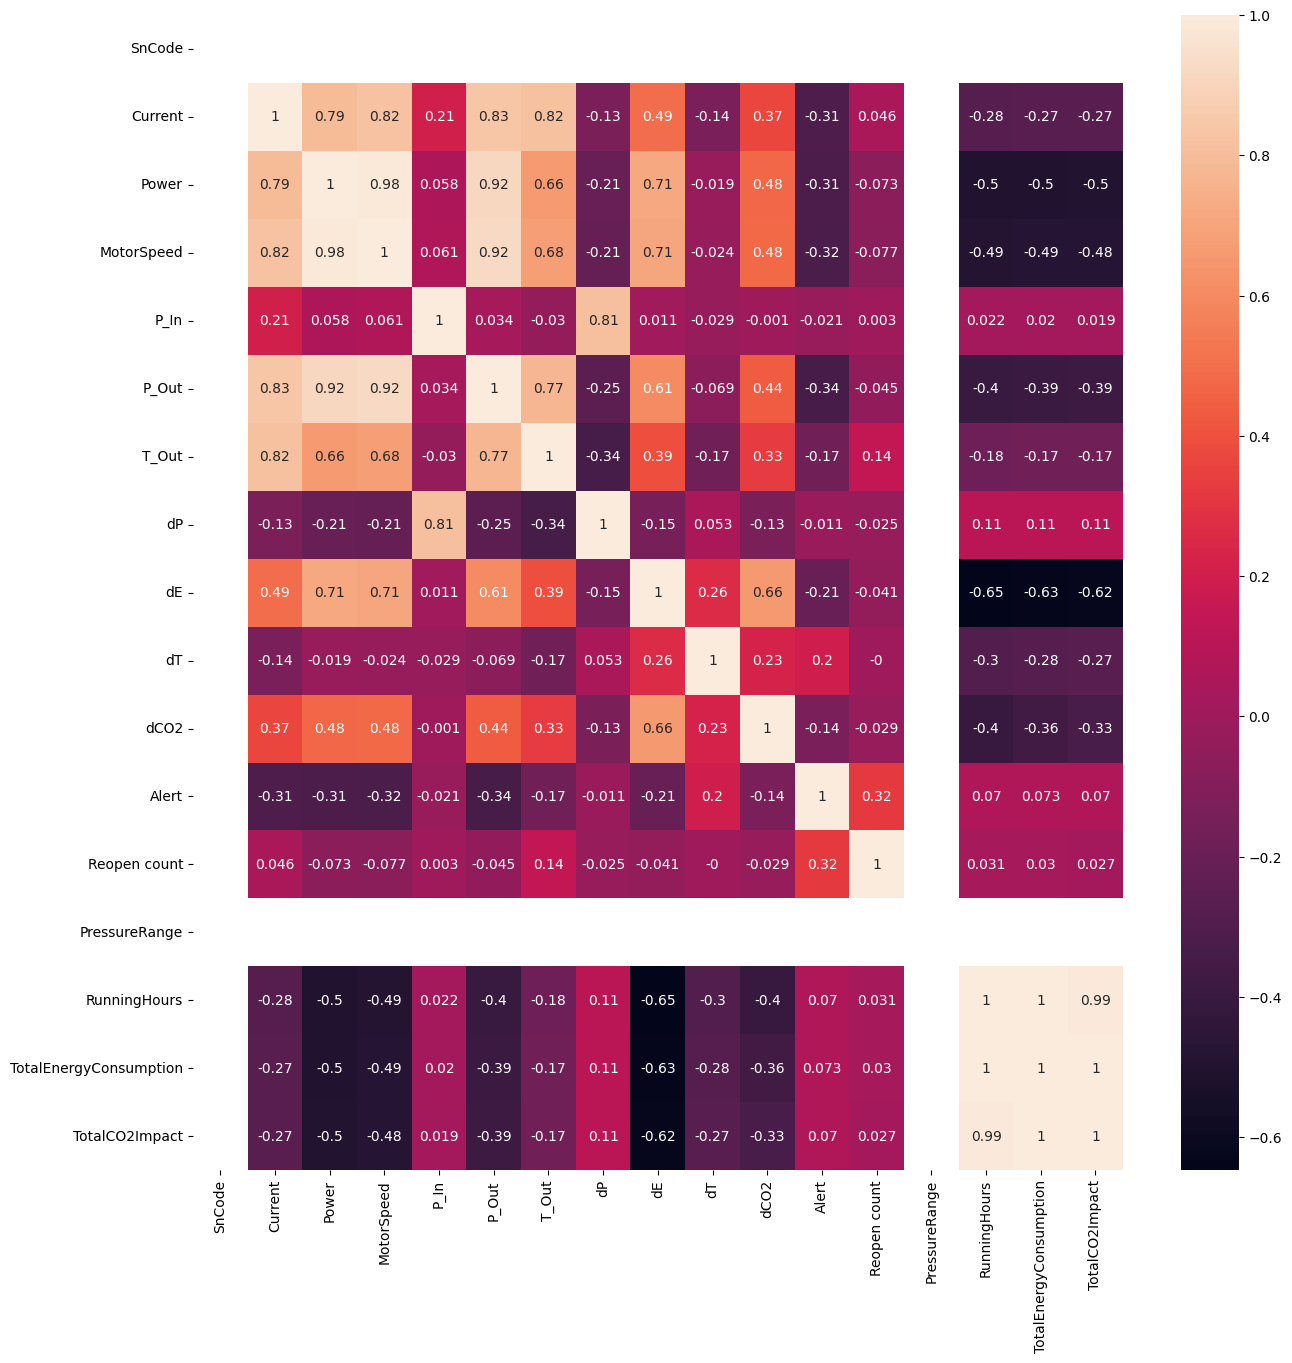

In [47]:
temp = df_cut.drop(columns=["TimeStamp","PumpCode"])
cor_matrix = temp.corr(min_periods=1).round(3)
plt.figure(figsize=[15,15])
sns.heatmap(cor_matrix, annot=True)
plt.show()

#### Visualising Single Pumps

<div style="text-align:justify">
The heatmap shows interesting but predictable correlations among the parameters. Therefore, the boxplots of the "P_In", "Power", and "MotorSpeed" illustrate the distribution of the parameter values amongst the pumps:

The displayed parameters show that the inlet pressure of the pump is stable and that the power and motorspeed are low for a GHS pump. 
<div>

c:\Users\a00546973\Desktop\MasterGENIUS\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a00546973\Desktop\MasterGENIUS\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a00546973\Desktop\MasterGENIUS\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a00546973\Desktop\MasterGENIUS\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

Text(0.5, 1.0, 'Histogram of MotorSpeed [rpm]')

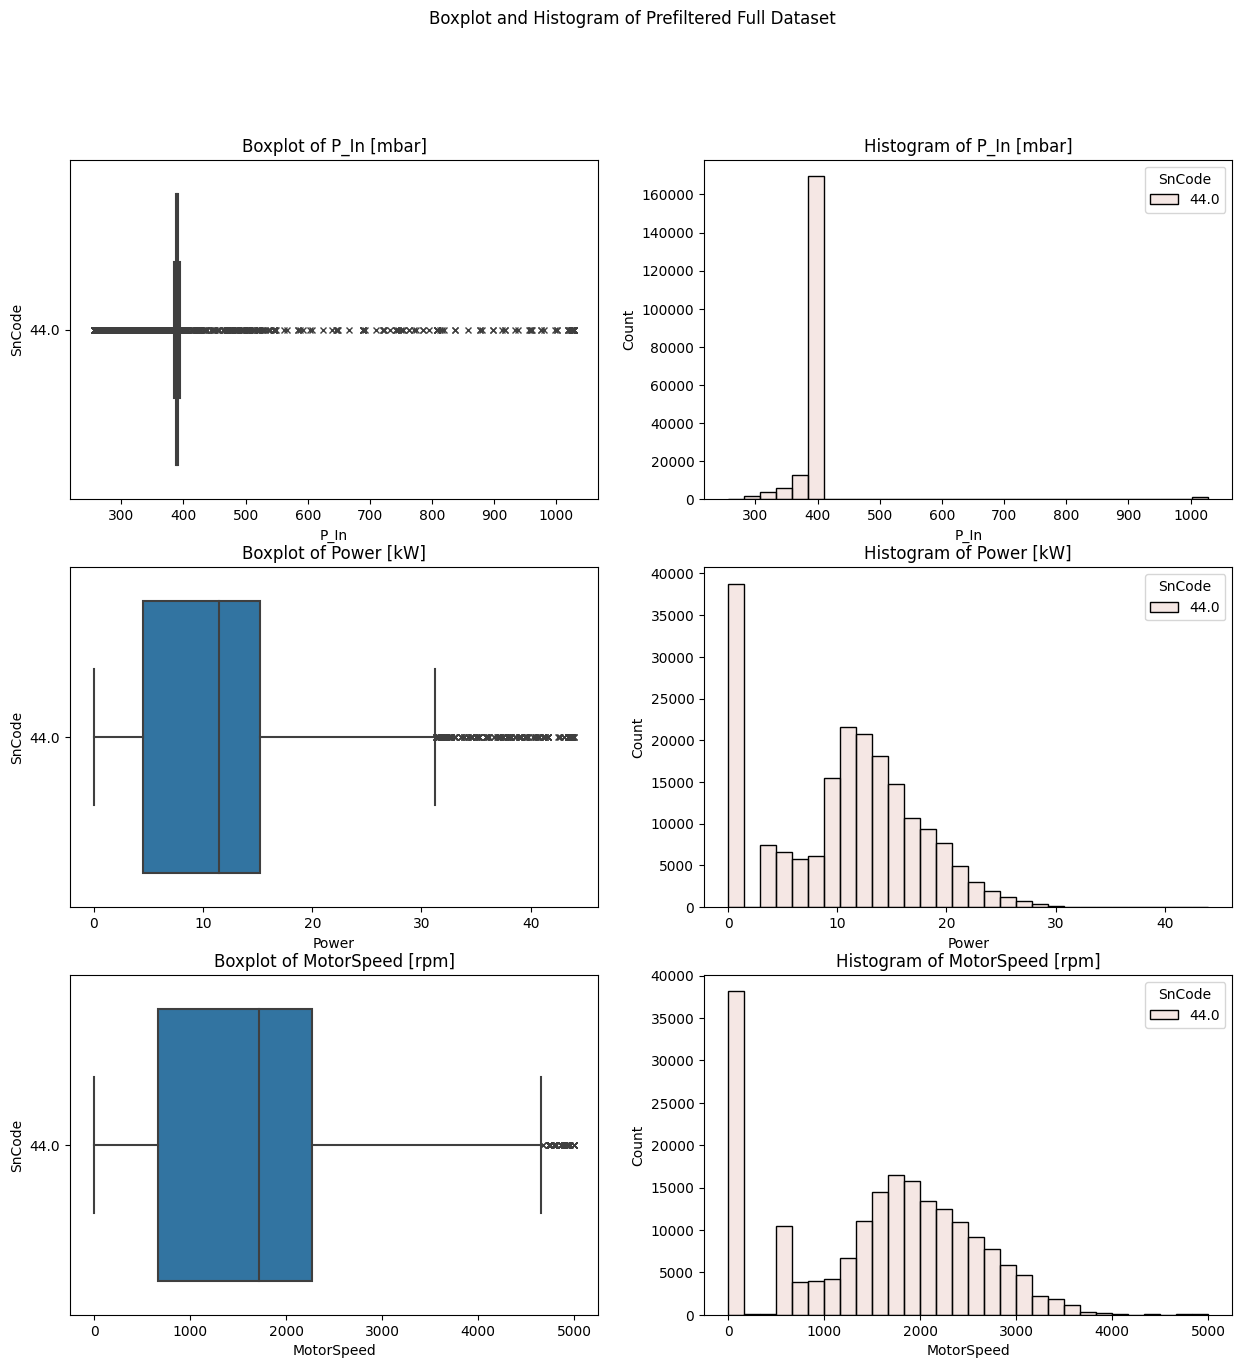

In [48]:
# Plotting boxplot and histogram with adjusted parameters

fig, axs = plt.subplots(3,2, figsize=(15,15))
plt.suptitle("Boxplot and Histogram of Prefiltered Full Dataset")

sns.boxplot(ax=axs[0,0], data=df_cut, x=df_cut["P_In"], y=df["SnCode"], flierprops={"marker":"x"}, orient="h")
axs[0,0].set_title("Boxplot of P_In [mbar]")
sns.histplot(ax=axs[0,1], data=df_cut, x=df_cut["P_In"], hue=df["SnCode"], bins=30)
axs[0,1].set_title("Histogram of P_In [mbar]")

sns.boxplot(ax=axs[1,0], data=df_cut, x="Power", y=df["SnCode"], flierprops={"marker":"x"}, orient="h")
axs[1,0].set_title("Boxplot of Power [kW]")
sns.histplot(ax=axs[1,1], data=df_cut, x=df_cut["Power"], hue=df["SnCode"], bins=30)
axs[1,1].set_title("Histogram of Power [kW]")

sns.boxplot(ax=axs[2,0], data=df_cut, x="MotorSpeed", y=df["SnCode"], flierprops={"marker":"x"}, orient="h")
axs[2,0].set_title("Boxplot of MotorSpeed [rpm]")
sns.histplot(ax=axs[2,1], data=df_cut, x=df_cut["MotorSpeed"], hue=df["SnCode"], bins=30)
axs[2,1].set_title("Histogram of MotorSpeed [rpm]")

In [49]:
# Save the processed data
run = "2"
path1 = "C:/Users/a00546973/Desktop/MasterGENIUS/Data/raw_df_"+run+".csv"
path2 = "C:/Users/a00546973/Desktop/MasterGENIUS/Data/cut_df_"+run+".csv"
df.to_csv(path1, index=False)
df_cut.to_csv(path2, index=False)